In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller


In [ ]:
df = pd.read_csv('data.csv')

Combine Date and Time columns into a single datetime column

In [ ]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing 'kWh' suffix

In [ ]:
df['Energy'] = df['Energy'].str.replace('kWh', '').astype(float)

In [ ]:
df.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df = df.resample('30min').last()

<ipython-input-68-a11cbd49addd>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('30T').last()


In [ ]:
df.head()

,Date,Time,Energy
DateTime,,,
2024-08-15 00:00:00,15/08/2024,12:25AM,0.0
2024-08-15 00:30:00,15/08/2024,12:55AM,0.0
2024-08-15 01:00:00,15/08/2024,1:25AM,0.0
2024-08-15 01:30:00,15/08/2024,1:55AM,0.0
2024-08-15 02:00:00,15/08/2024,2:25AM,0.0


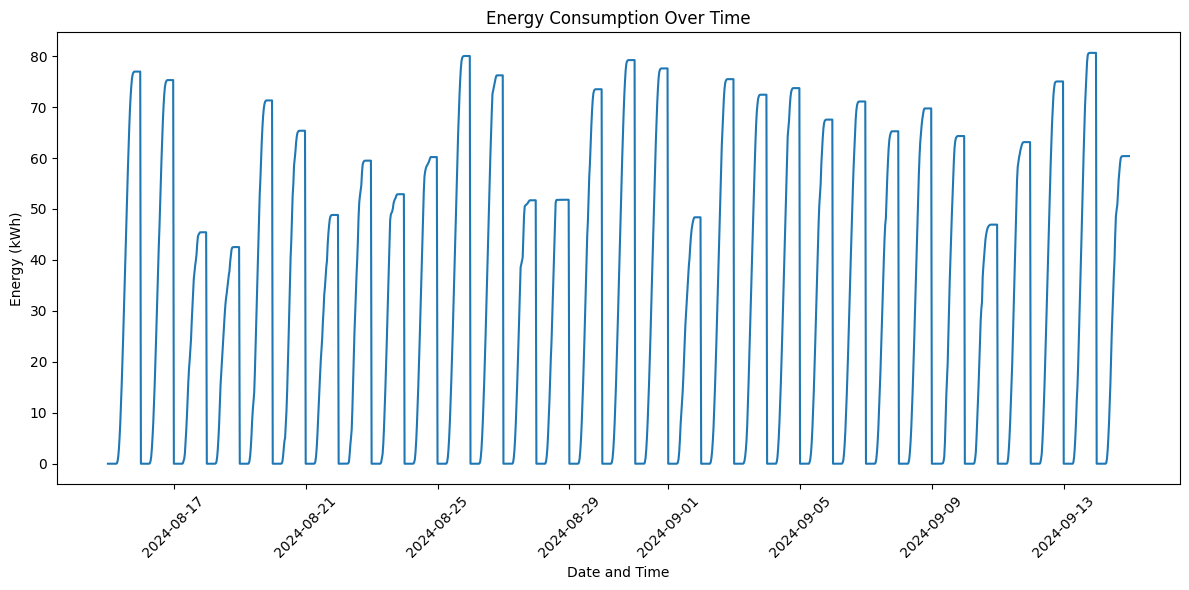

In [ ]:

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.470848e+01
p-value                        2.872302e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.464000e+03
Critical Value (1%)           -3.434825e+00
Critical Value (5%)           -2.863516e+00
Critical Value (10%)          -2.567822e+00
dtype: float64


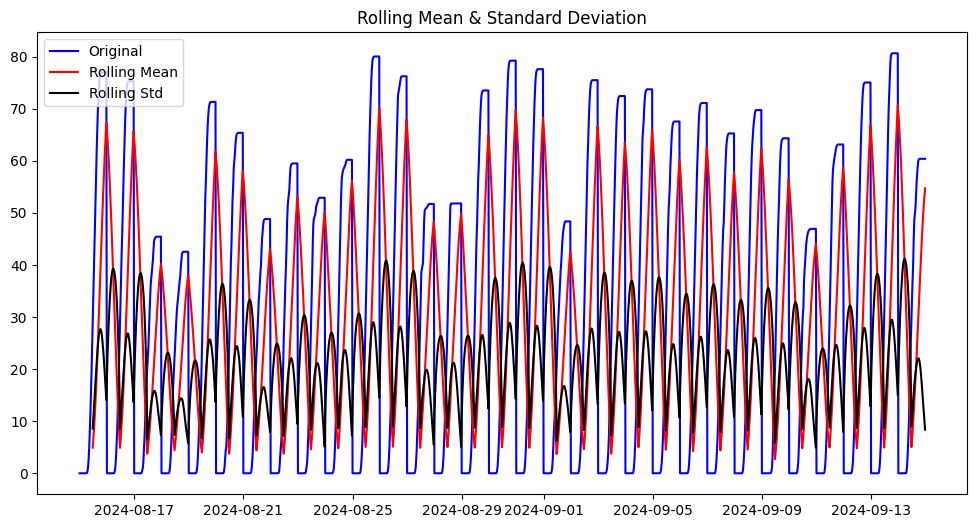

In [ ]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Plot rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    plt.figure(figsize=(12,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Check stationarity
check_stationarity(df['Energy'])


The test statistic (-14.71) is much lower (more negative) than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value (2.87e-27) is significantly smaller than 0.05, meaning we reject the null hypothesis of non-stationarity. Therefore, the data are considered stationary.

In [ ]:
df = df.reset_index()

In [ ]:
df = df.rename(columns={'DateTime': 'ds', 'Energy': 'y'})

In [ ]:
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
columns_to_keep = ['ds', 'y']
df = df[columns_to_keep]

In [ ]:
df.head()

,ds,y
0,2024-08-15 00:00:00,0.0
1,2024-08-15 00:30:00,0.0
2,2024-08-15 01:00:00,0.0
3,2024-08-15 01:30:00,0.0
4,2024-08-15 02:00:00,0.0


Split the data into training and testing sets (80% train, 20% test)

In [ ]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

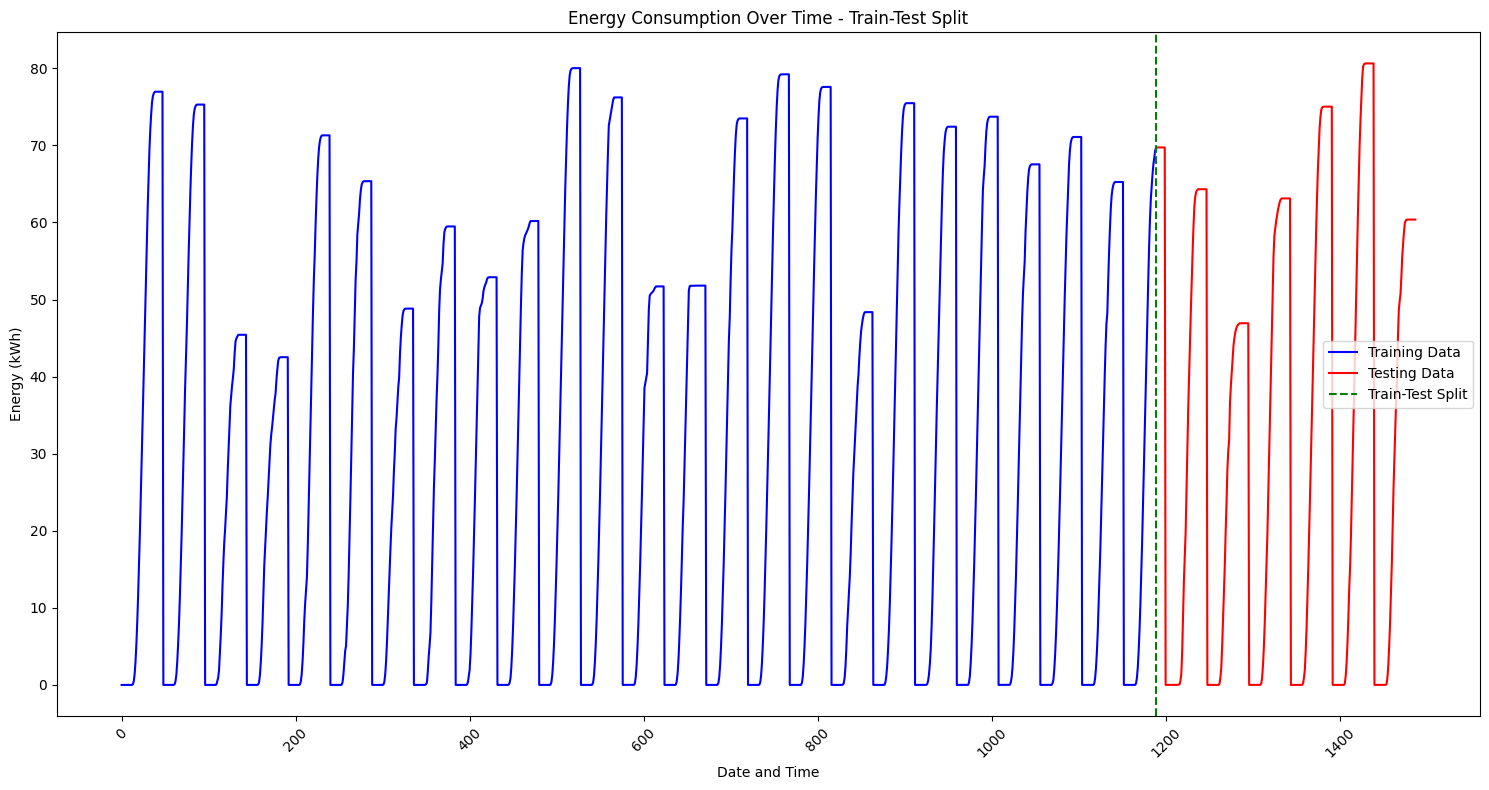

In [ ]:
plt.figure(figsize=(15, 8))

# Plot training data
plt.plot(train_data.index, train_data['y'], label='Training Data', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data['y'], label='Testing Data', color='red')

# Add a vertical line to show the split point
split_date = train_data.index[-1]
plt.axvline(x=split_date, color='green', linestyle='--', label='Train-Test Split')

plt.title('Energy Consumption Over Time - Train-Test Split')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# Fit the model
model.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpu02tmz0c/_amvd8dn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu02tmz0c/tbcc2eug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40801', 'data', 'file=/tmp/tmpu02tmz0c/_amvd8dn.json', 'init=/tmp/tmpu02tmz0c/tbcc2eug.json', 'output', 'file=/tmp/tmpu02tmz0c/prophet_modeloxcw1dxc/prophet_model-20241012202842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Trend Flexibility (changepoint_prior_scale=0.05): Chosen to allow moderate flexibility in the trend while avoiding overfitting.

Seasonality Flexibility (seasonality_prior_scale=10): Allows for more complex, volatile seasonal patterns common in solar energy production.

Daily, Weekly, Yearly Seasonality (daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True): Enabled to capture the natural daily, weekly, and yearly cycles of solar energy.

Multiplicative Seasonality (seasonality_mode='multiplicative'): Chosen because seasonal effects are likely proportional to the trend in solar energy data.

In [ ]:
future = model.make_future_dataframe(periods=48*7, freq='30T')
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


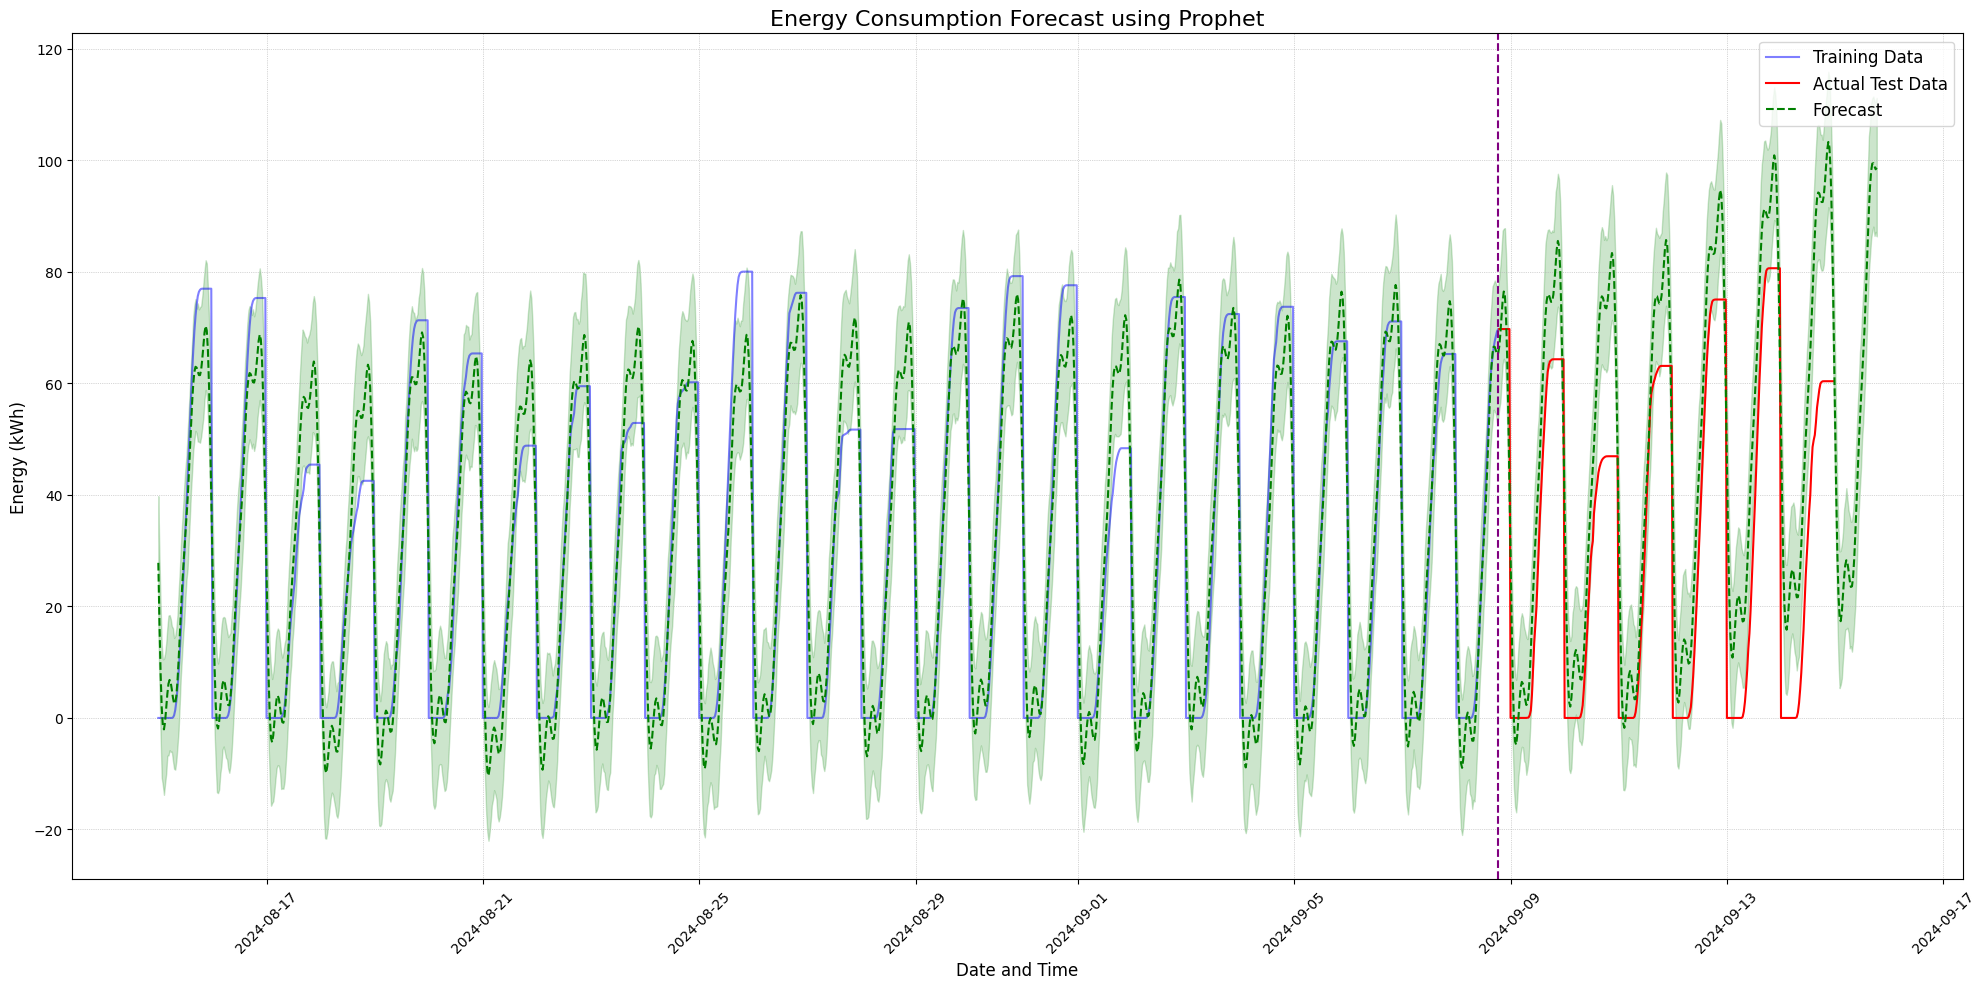

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='blue', alpha=0.5)
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='green', alpha=0.2)

plt.title('Energy Consumption Forecast using Prophet', fontsize=16)
plt.legend(fontsize=12)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Add vertical line to show train-test split
split_date = train_data['ds'].iloc[-1]
plt.axvline(x=split_date, color='purple', linestyle='--', label='Train-Test Split')

plt.tight_layout()
plt.show()

In [ ]:
y_true = test_data['y'].values
y_pred = forecast.tail(len(test_data))['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"Root Mean Square Error: {rmse:.2f} kWh")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Mean Absolute Error: 29.47 kWh
Root Mean Square Error: 41.23 kWh
Mean Absolute Percentage Error: inf%


<ipython-input-79-de4b29a75935>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


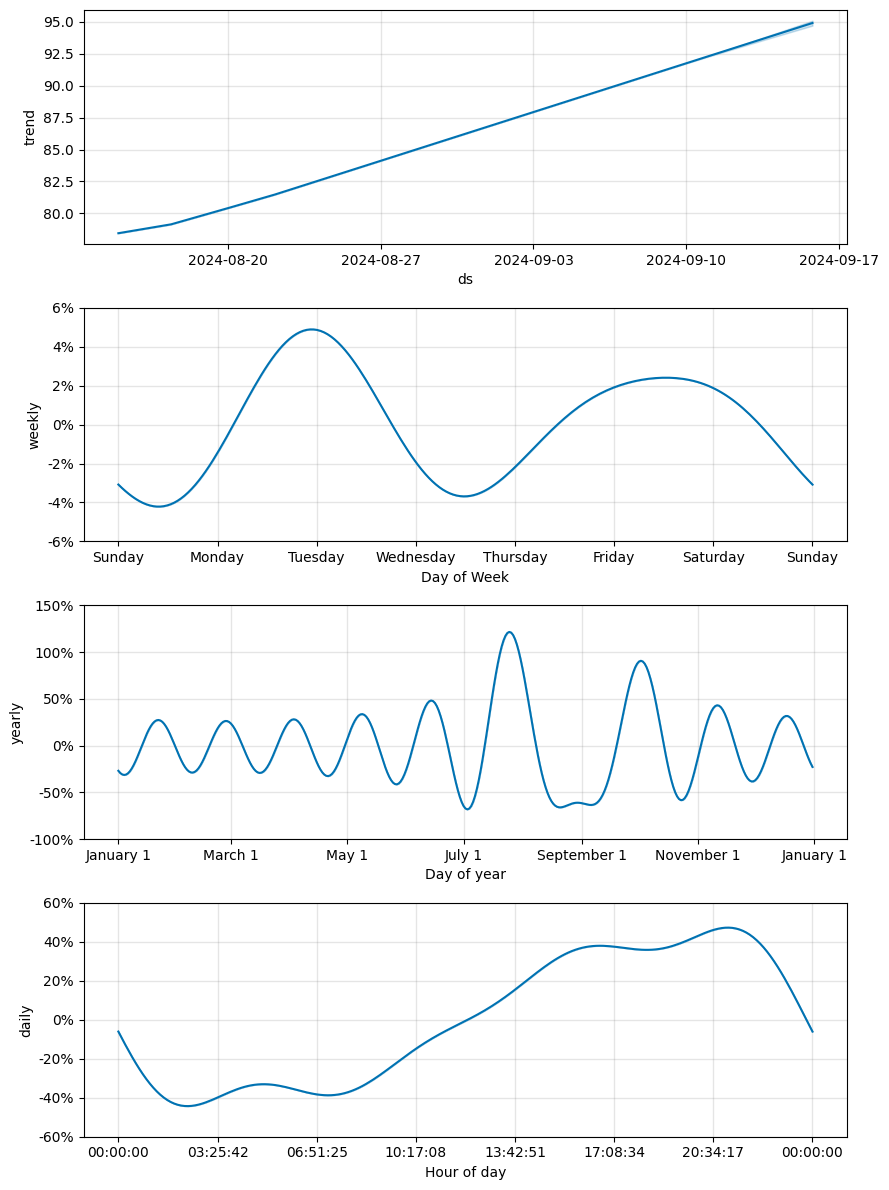

In [ ]:
model.plot_components(forecast)
plt.show()